In [333]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
register_matplotlib_converters()

In [334]:
#Read data
csv_file = 'MSFT.csv'
df = pd.read_csv('DataSet\\'+csv_file)
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1986-03-14,0.097222,0.102431,0.097222,0.100694,0.063158,308160000
1,1986-03-17,0.100694,0.103299,0.100694,0.102431,0.064247,133171200
2,1986-03-18,0.102431,0.103299,0.098958,0.099826,0.062613,67766400
3,1986-03-19,0.099826,0.100694,0.097222,0.098090,0.061524,47894400
4,1986-03-20,0.098090,0.098090,0.094618,0.095486,0.059891,58435200


In [335]:
#Data cleaning
df_clean = df.loc[:,['Date','Close']]
df_clean.rename(columns={'Date':'date','Close':'close'},inplace=True)
df_clean['date'] = pd.to_datetime(df_clean.date)
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9204 entries, 0 to 9203
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    9204 non-null   datetime64[ns]
 1   close   9204 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 143.9 KB


In [336]:
#Subseting data
df_clean.set_index('date',inplace=True)
start_date = pd.to_datetime('2012-01-01')
df_clean = df_clean[start_date:]
df_clean.head()

,close
date,
2012-01-03,26.770000
2012-01-04,27.400000
2012-01-05,27.680000
2012-01-06,28.110001
2012-01-09,27.740000


In [337]:
#Useful functions
#Print Graph
def plotgraph(dataframe, column, plottitle, plotylabel, startyear, endyear):
    plt.figure(figsize=(10,4))
    plt.plot(dataframe[column])
    plt.title(plottitle, fontsize=20)
    plt.ylabel(plotylabel, fontsize=16)
    for year in range(startyear,endyear):
        plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

#Augmented Dickey-Fuller (ADF) Test:
#Null hypothesis: non-stationary - if p-value < 5% reject null hypothesis
def ADFtest(dataframe, column):
    adfuller_result = adfuller(dataframe[column].values, autolag='AIC')
    print(f'ADF statistic: {adfuller_result[0]}')
    print(f'p-value      : {adfuller_result[1]}')
    for key, value in adfuller_result[4].items():
        print('Critical values:')
        print(f'  {key},  {value}')
    if (adfuller_result[1] < 0.05):
        print('It is stationary')
    else:
        print('It is non-stationary')

ADF statistic: 0.1041027567084489
p-value      : 0.9663400945397638
Critical values:
  1%,  -3.4327951182428817
Critical values:
  5%,  -2.8626202716505262
Critical values:
  10%,  -2.567345065113533
It is non-stationary


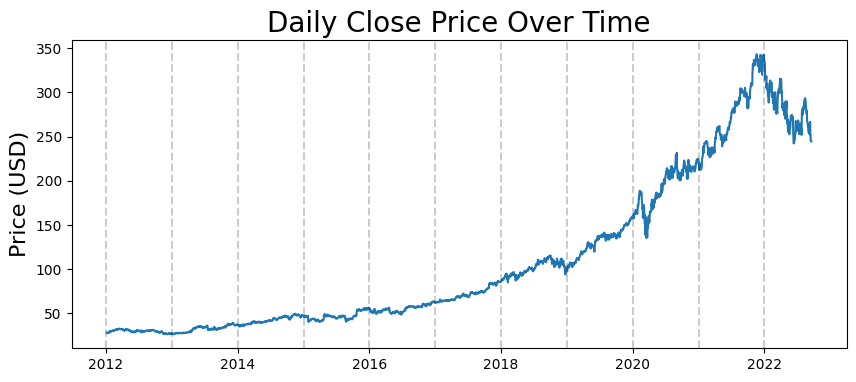

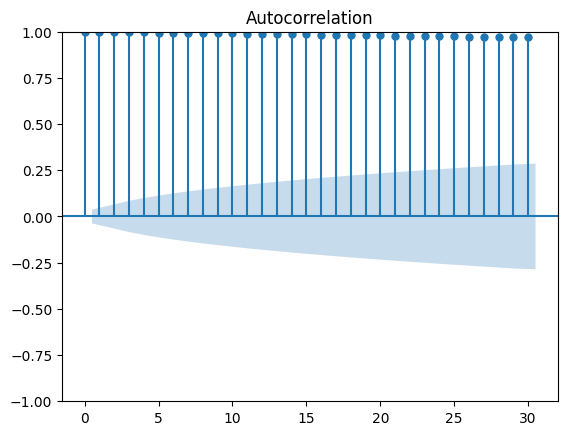

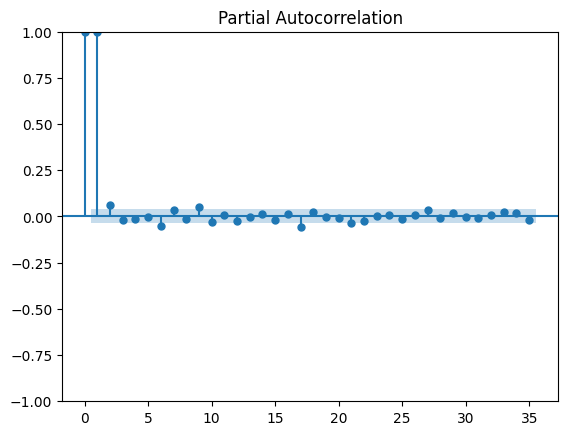

In [344]:
ADFtest(df_clean,'close')
plotgraph(df_clean,'close','Daily Close Price Over Time','Price (USD)',2012,2023)
adc_plot = plot_acf(df_clean.close,  alpha=.05, lags=30)
pacf_plot = plot_pacf(df_clean.close,  alpha=.05, method='ywm')

ADF statistic: -0.24754619478423362
p-value      : 0.932611813756184
Critical values:
  1%,  -3.432789644973554
Critical values:
  5%,  -2.8626178545085774
Critical values:
  10%,  -2.56734377821929
It is non-stationary


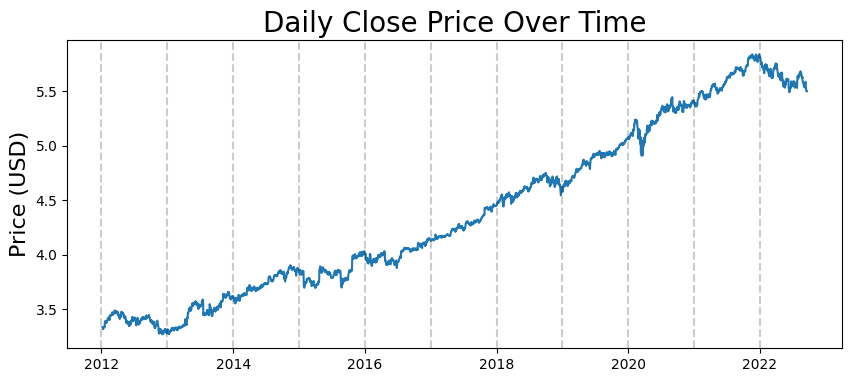

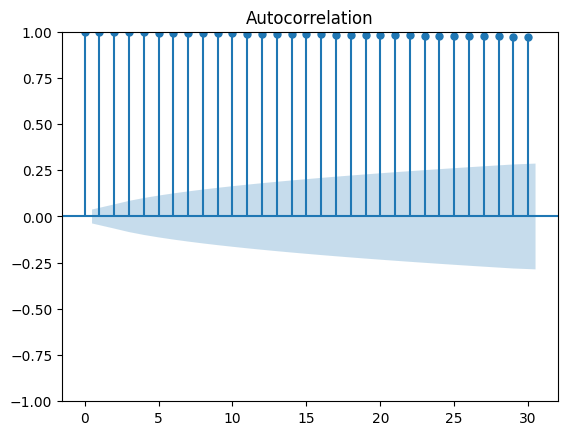

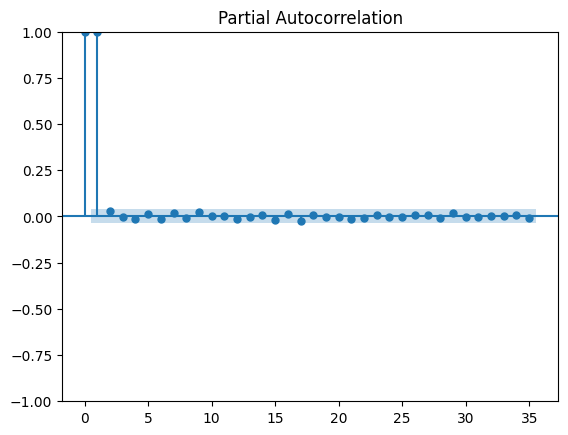

In [345]:
#Log Transformation
df_clean['adj_log'] = np.log(df_clean['close'])
ADFtest(df_clean,'adj_log')
plotgraph(df_clean,'adj_log','Daily Close Price Over Time','Price (USD)',2012,2023)
adc_plot = plot_acf(df_clean.adj_log, alpha=.05, lags=30)
# “ywm” : Yule-Walker without adjustment. Default.
# “yw”  : Yule-Walker with sample-size adjustment in denominator for acovf. Default.
#alpha  : 0.05 = 95% confidence interval
pacf_plot = plot_pacf(df_clean.adj_log, alpha=.05, method='ywm')

ADF statistic: -18.622798108615765
p-value      : 2.0606030065902194e-30
Critical values:
  1%,  -3.432788735143374
Critical values:
  5%,  -2.862617452702835
Critical values:
  10%,  -2.5673435642966767
It is stationary


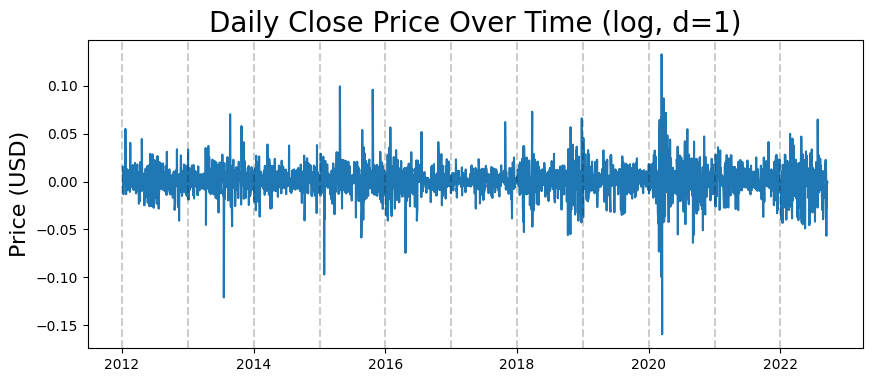

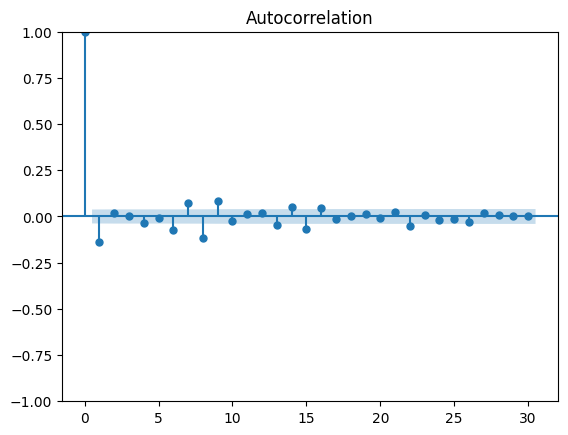

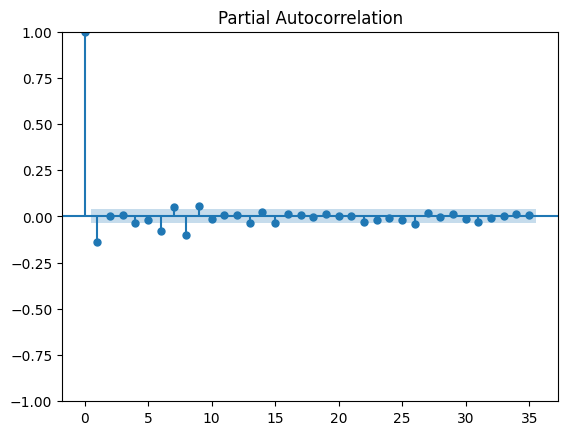

In [342]:
#Differencing
df_clean['difference_1'] = df_clean['adj_log'] - df_clean['adj_log'].shift(1)
df_clean.dropna(inplace=True)
ADFtest(df_clean,'difference_1')
plotgraph(df_clean,'difference_1','Daily Close Price Over Time (log, d=1)','Price (USD)',2012,2023)
adc_plot = plot_acf(df_clean.difference_1, alpha=.05,lags=30)
pacf_plot = plot_pacf(df_clean.difference_1, alpha=.05,method='ywm')